# 4 Task A: Individual Neural Networks for Each Forecast Horizon

## 4.1 Data Preparation

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error

### (a) Load the data from Nino3.4 data.csv

In [56]:
data = pd.read_csv("Nino3.4_data.csv")

### (b) Read test years from test years.csv. Extract all data rows from step (a) that match these test years to create your test set. This test data must remain untouched during training. You should use this test set to evaluate your model’s performance and report results

In [57]:
test_years = pd.read_csv("test_years.csv")["year"].tolist()

### (c) Subset your test data based on the test years, then randomly partition the remainingdataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation.

In [58]:
test_data = data[data["year"].isin(test_years)].reset_index(drop=True)
train_val_data = data[~data["year"].isin(test_years)].reset_index(drop=True)

# 在剩余数据中随机划分训练集与验证集
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, shuffle=True)

### (d) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse transformation during evaluation. Apply the same transformations to the validation set.

Optional: You might also consider creating additional features from the month column. For example, some students find it helpful to encode the cyclical nature of months using sine and cosine transformations: sin(2π × month/12) and cos(2π × month/12). This can help the model understand that December is adjacent to January.

Note: Save your scaler objects for later use (e.g., using pickle or joblib).

In [59]:
# 输入特征与目标列
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# 可选：添加月份的正弦余弦特征
for df in [train_data, val_data, test_data]:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # 将它们加入输入特征中
    df.reset_index(drop=True, inplace=True)

input_features_extended = input_features + ["month_sin", "month_cos"]

# 缩放输入特征
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_data[input_features_extended])
val_X_scaled = scaler_X.transform(val_data[input_features_extended])
test_X_scaled = scaler_X.transform(test_data[input_features_extended])

# 可选：缩放目标变量
scale_targets = True  # ← 如果不希望缩放，改成 False
if scale_targets:
    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_data[target_features])
    val_y_scaled = scaler_y.transform(val_data[target_features])
    test_y_scaled = scaler_y.transform(test_data[target_features])

# 保存缩放器以供后续反缩放或预测使用
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# ---------- 转换为 PyTorch 张量 ----------
train_X = torch.tensor(train_X_scaled, dtype=torch.float32)
val_X = torch.tensor(val_X_scaled, dtype=torch.float32)
test_X = torch.tensor(test_X_scaled, dtype=torch.float32)

train_y = torch.tensor(train_y_scaled, dtype=torch.float32)
val_y = torch.tensor(val_y_scaled, dtype=torch.float32)
test_y = torch.tensor(test_y_scaled, dtype=torch.float32)

# ---------- 创建 TensorDataset ----------
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# 示例：构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 584
Val size: 146
Test size: 72


### (e) Train a neural network that predicts the Ni˜no3.4 index of the next month, i.e.nino tplus1 using reasonable hyperparameters. Ensure reproducibility by setting a seed throughout your code. Plot the training and validation loss curves across epochs.
Note: Save your trained models in a format appropriate for your chosen framework. Common formats include .keras, .h5, .pth, .pt, or .onnx. Ensure your models can be loaded during evaluation

In [60]:
# ---------- 设置随机种子以确保可复现性 ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 定义神经网络 ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_X.shape[1]
model = NinoNet(input_dim).to(device)


### (f) Repeat (e) for the subsequent months, i.e., nino_tplus2, nino_tplus3,.. nino_tplus6. Together with part (e), this will give you six trained networks and six plots for training and validation loss, shown in one Figure


===== Training Model for Horizon 1 Month =====
Epoch [10/1000] Train Loss: 0.5701, Val Loss: 0.4861
Epoch [20/1000] Train Loss: 0.2137, Val Loss: 0.2008
Epoch [30/1000] Train Loss: 0.1637, Val Loss: 0.1586
Epoch [40/1000] Train Loss: 0.1439, Val Loss: 0.1407
Epoch [50/1000] Train Loss: 0.1385, Val Loss: 0.1265
Epoch [60/1000] Train Loss: 0.1201, Val Loss: 0.1175
Epoch [70/1000] Train Loss: 0.1194, Val Loss: 0.1100
Epoch [80/1000] Train Loss: 0.1157, Val Loss: 0.1048
Epoch [90/1000] Train Loss: 0.1069, Val Loss: 0.1014
Epoch [100/1000] Train Loss: 0.0951, Val Loss: 0.0975
Epoch [110/1000] Train Loss: 0.0987, Val Loss: 0.0951
Epoch [120/1000] Train Loss: 0.0992, Val Loss: 0.0962
Epoch [130/1000] Train Loss: 0.0999, Val Loss: 0.0933
Epoch [140/1000] Train Loss: 0.0926, Val Loss: 0.0916
Epoch [150/1000] Train Loss: 0.0937, Val Loss: 0.0920
Early stopping at epoch 150
 模型 nino_model_tplus1.pth 已保存

===== Training Model for Horizon 2 Month =====
Epoch [10/1000] Train Loss: 0.6064, Val Loss:

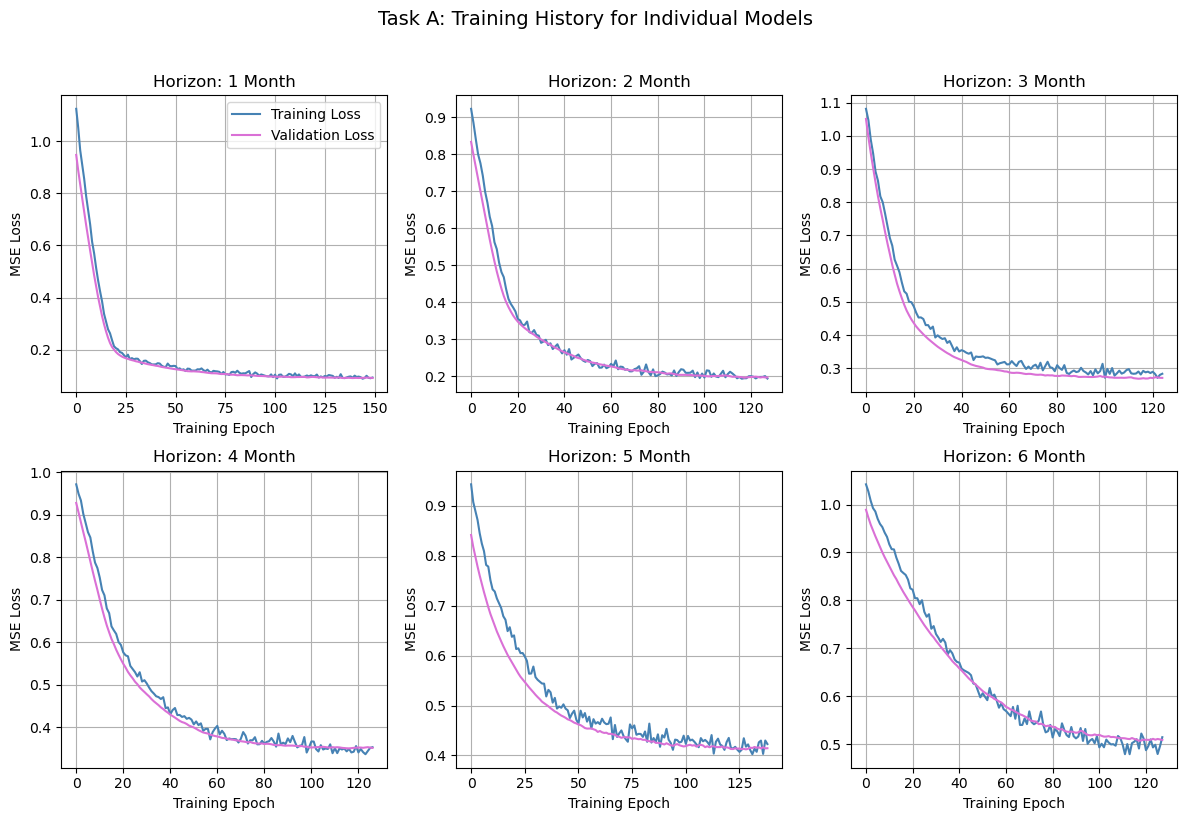

In [86]:
# ---------- 训练函数 ----------
def train_single_horizon(horizon_index, epochs=1000, lr=1e-4, batch_size=32, patience=10):
    # 目标列索引
    y_train_h = train_y[:, horizon_index].unsqueeze(1)
    y_val_h = val_y[:, horizon_index].unsqueeze(1)

    # 数据加载
    train_dataset = TensorDataset(train_X, y_train_h)
    val_dataset = TensorDataset(val_X, y_val_h)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型定义
    model = NinoNet(train_X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # 记录损失
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # --------- 训练 ---------
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # --------- 验证 ---------
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # --------- Early Stopping ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}  # 保存最优权重
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # 保存模型
    torch.save(model.state_dict(), f"nino_model_tplus{horizon_index+1}.pth")
    print(f" 模型 nino_model_tplus{horizon_index+1}.pth 已保存")

    return train_losses, val_losses


# ---------- 主训练循环 ----------
all_train_losses, all_val_losses = [], []
num_models = 6
for i in range(num_models):
    print(f"\n===== Training Model for Horizon {i+1} Month =====")
    t_loss, v_loss = train_single_horizon(i)
    all_train_losses.append(t_loss)
    all_val_losses.append(v_loss)


# ---------- 绘制六张训练曲线 ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_models):
    ax = axes[i]
    ax.plot(all_train_losses[i], label="Training Loss", color="steelblue")
    ax.plot(all_val_losses[i], label="Validation Loss", color="orchid")
    ax.set_title(f"Horizon: {i+1} Month")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.suptitle("Task A: Training History for Individual Models", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### (j) Apply the same transformations to the test set as you did to the training and validation sets

In [87]:
# 假设 scaler_X 是在 (d) 中已经 fit 过的输入特征缩放器
# 如果你也对目标缩放过（可选），那也有 scaler_y
# 加载保存好的 scaler
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# ⚠️ 这里我们不重新fit，只transform
X_features = ['nino_tminus2', 'nino_tminus1', 'nino_t', 'month_sin', 'month_cos']
y_targets = ['nino_tplus1', 'nino_tplus2', 'nino_tplus3', 
             'nino_tplus4', 'nino_tplus5', 'nino_tplus6']

# 输入特征 transform（与训练集同一 scaler）
X_test_scaled = scaler_X.transform(test_data[X_features])
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# 为评估准备：不要对单列用 scaler_y.transform（会报错）
# 我们只保留原始真实值方便后面计算评估指标（以原始单位）
y_test_orig = test_data[y_targets].values  # shape (N,6)

print("测试集转换完成：")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_orig: {y_test_orig.shape}")

测试集转换完成：
X_test_tensor: torch.Size([72, 5]), y_test_orig: (72, 6)


### (k) Use your models to forecast the Ni˜no3.4 index on the test set for the months ahead they are designed for

In [88]:
# 假设模型结构一致
class NinoNet(nn.Module):
    def __init__(self, input_dim):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 载入模型并预测
horizons = [1, 2, 3, 4, 5, 6]
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# scaler_y.mean_ 和 scale_ 可用于单列反缩放
means = scaler_y.mean_        # 长度为6
scales = scaler_y.scale_      # 长度为6
# scaler_y.feature_names_in_ 也可用于确认列序


### (l) Evaluate each model by calculating the RMSE and Pearson Correlation Coefficient between the predicted and true values (as defined in Section 3.4).

In [89]:
for h in horizons:
    # 加载模型
    model = NinoNet(input_dim=X_test_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(f"nino_model_tplus{h}.pth", map_location=device))
    model.eval()  # 重要：关闭 Dropout

    # 预测
    with torch.no_grad():
        preds_scaled = model(X_test_tensor).cpu().numpy().reshape(-1,1)  # (N,1)

    # 反缩放 - 使用 scaler_y 对应列的 mean/scale（手动反缩放，避免 sklearn 的列名校验）
    col_idx = h - 1  # tplus1 -> idx0, tplus6 -> idx5
    preds_orig = preds_scaled * scales[col_idx] + means[col_idx]  # (N,1)
    true_orig = y_test_orig[:, col_idx].reshape(-1,1)            # (N,1)

    # 评估在原尺度
    rmse = math.sqrt(mean_squared_error(true_orig, preds_orig))
    corr, _ = pearsonr(true_orig.flatten(), preds_orig.flatten())

    results.append({"Horizon (month ahead)": h, "RMSE": rmse, "Pearson r": corr})

### (m) Display results in a table showing RMSE and correlation coefficients for each forecast horizon (1-6 months ahead

In [90]:
# 汇总结果表
results_df = pd.DataFrame(results)
print("📊 预测评估结果：")
print(results_df.to_string(index=False))

📊 预测评估结果：
 Horizon (month ahead)     RMSE  Pearson r
                     1 0.212814   0.976029
                     2 0.361830   0.925684
                     3 0.478902   0.866146
                     4 0.569458   0.800615
                     5 0.643013   0.736551
                     6 0.711410   0.673561


### 4.4 Model Improvements
(n) Apply a strategy that involves transfer learning to the model that predicts nino tplus6 and calculate the RMSE and correlation coefficient on the testing data.
Hint: First train a model on an easier task such as nino tplus1, then continue
training the same model to predict nino tplus6

In [92]:
# ---------- (n) Transfer Learning for Nino_tplus6 (修正后) ----------
# 使用之前的 train_X_scaled, test_X_scaled，和 scaler_y 的 mean/scale 做单列缩放

# 准备 tensors
X_train_tensor = torch.tensor(train_X_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(test_X_scaled, dtype=torch.float32).to(device)

# 手动缩放单列 target（使用 scaler_y.mean_ / scale_）
col_idx = list(scaler_y.feature_names_in_).index('nino_tplus6')  # 确认索引
y_train_tplus6 = train_data[['nino_tplus6']].values.astype(float).reshape(-1,1)
y_test_tplus6  = test_data[['nino_tplus6']].values.astype(float).reshape(-1,1)

y_train_tplus6_scaled = (y_train_tplus6 - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]
y_test_tplus6_scaled  = (y_test_tplus6  - scaler_y.mean_[col_idx]) / scaler_y.scale_[col_idx]

y_train_tplus6_tensor = torch.tensor(y_train_tplus6_scaled, dtype=torch.float32).to(device)
y_test_tplus6_tensor  = torch.tensor(y_test_tplus6_scaled, dtype=torch.float32).to(device)

# 加载模型并替换最后层
source_model_path = "nino_model_tplus1.pth"
target_model_path = "nino_model_transfer_tplus6.pth"

input_dim = X_train_tensor.shape[1]
model = NinoNet(input_dim).to(device)
model.load_state_dict(torch.load(source_model_path, map_location=device))

# 替换输出层（确保输出是单一回归）
model.model[-1] = nn.Linear(32, 1).to(device)

# 冻结底层 1~2 层，微调中间层 + 输出层，让模型有能力适应 tplus6
for p in model.model[:2].parameters():  # 冻结前两层
    p.requires_grad = False
for p in model.model[2:].parameters():  # 微调后两层
    p.requires_grad = True

# 重新定义优化器（只包含可训练参数）
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# 划分验证子集以基于 val_loss 做 early stopping
from sklearn.model_selection import train_test_split
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train_tensor.cpu(), y_train_tplus6_tensor.cpu(), test_size=0.2, random_state=42
)
X_tr_sub, X_val_sub = X_tr_sub.to(device), X_val_sub.to(device)
y_tr_sub, y_val_sub = y_tr_sub.to(device), y_val_sub.to(device)

best_val_loss = float('inf')
patience = 10   # 允许连续多少个 epoch val_loss 不降
patience_counter = 0
epochs = 3000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_tr_sub)
    loss = criterion(out, y_tr_sub)
    loss.backward()
    optimizer.step()
    
    # 验证集评估
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_sub)
        val_loss = criterion(val_pred, y_val_sub)

    
    # Early stopping 检查
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # 保存当前最优权重（可选）
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 保存最优权重（若有 best_state 用 best_state）
if 'best_state' in locals():
    torch.save(best_state, target_model_path)
else:
    torch.save(model.state_dict(), target_model_path)
print("迁移模型已保存：", target_model_path)

# 在测试集上评估（反缩放）
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()  # (N,1)

# 反缩放
y_pred_orig = y_pred_scaled * scaler_y.scale_[col_idx] + scaler_y.mean_[col_idx]
y_true_orig = y_test_tplus6  # 已在前面定义为原始真实值

rmse_transfer = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
corr_transfer, _ = pearsonr(y_true_orig.flatten(), y_pred_orig.flatten())

print("\n📈 Transfer Learning Results for Nino_tplus6:")
print(f"RMSE: {rmse_transfer:.4f}")
print(f"Pearson r: {corr_transfer:.4f}")

Epoch [10/3000] Train Loss: 0.8564, Val Loss: 0.9760
Epoch [20/3000] Train Loss: 0.7650, Val Loss: 0.8948
Epoch [30/3000] Train Loss: 0.7002, Val Loss: 0.8465
Epoch [40/3000] Train Loss: 0.6440, Val Loss: 0.8059
Epoch [50/3000] Train Loss: 0.6088, Val Loss: 0.7685
Epoch [60/3000] Train Loss: 0.5603, Val Loss: 0.7331
Epoch [70/3000] Train Loss: 0.5529, Val Loss: 0.7009
Epoch [80/3000] Train Loss: 0.5366, Val Loss: 0.6781
Epoch [90/3000] Train Loss: 0.5186, Val Loss: 0.6595
Epoch [100/3000] Train Loss: 0.5143, Val Loss: 0.6427
Epoch [110/3000] Train Loss: 0.4804, Val Loss: 0.6347
Epoch [120/3000] Train Loss: 0.5141, Val Loss: 0.6240
Epoch [130/3000] Train Loss: 0.4996, Val Loss: 0.6184
Epoch [140/3000] Train Loss: 0.4768, Val Loss: 0.6155
Epoch [150/3000] Train Loss: 0.4818, Val Loss: 0.6102
Epoch [160/3000] Train Loss: 0.4858, Val Loss: 0.6080
Epoch [170/3000] Train Loss: 0.4897, Val Loss: 0.6037
Epoch [180/3000] Train Loss: 0.4725, Val Loss: 0.6010
Epoch [190/3000] Train Loss: 0.4765, 